In [1]:
import os
import sys
import shutil
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from shutil import unpack_archive, make_archive

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from modis_utils.modis_utils import ModisUtils
from modis_utils.misc import restore_data, get_water_area
from modis_utils.model.loss_function import PSNRLoss, lossSSIM, SSIM, step_decay
from modis_utils.model.loss_function import mse_with_mask_tf, mse_with_mask_tf_1, mse_with_mask

# Parameters

In [3]:
config_path = 'config.dat'
config_params = restore_data(config_path)

In [4]:
lr = config_params['lr']

In [5]:
training = False
crop_size = config_params['crop_size']
input_timesteps = config_params['input_timesteps']
output_timesteps = config_params['output_timesteps']
batch_size = config_params['batch_size']
compile_params = config_params['compile_params']
model_name = config_params['model_name']
preprocessed_type = config_params['preprocessed_type']
modis_product = config_params['modis_product']
monitor = config_params['monitor']
monitor_mode = config_params['monitor_mode']
resize_input = config_params['resize_input']

raw_data_dir = config_params['raw_data_dir']
reservoir_index = config_params['reservoir_index']
used_band = config_params['used_band']
year_range = config_params['year_range']
model_keras = config_params['model_keras']
original_batch_size = config_params['original_batch_size']

TPU_FLAG = False

# End Parameters

In [6]:
modis_utils = ModisUtils(
    raw_data_dir=raw_data_dir,
    modis_product=modis_product,
    reservoir_index=reservoir_index,
    preprocessed_type=preprocessed_type,
    used_band=used_band,
    crop_size=crop_size,
    input_timesteps=input_timesteps,
    output_timesteps=output_timesteps,
    year_range=year_range,
    model_name=model_name,
    batch_size=batch_size,
    model_keras=model_keras,
    compile_params=compile_params,
    original_batch_size=original_batch_size,
    TPU_FLAG=TPU_FLAG,
    training=training,
    monitor=monitor,
    monitor_mode=monitor_mode,
    resize_input=resize_input)

In [7]:
loss_arr = modis_utils.eval_all()

In [9]:
modis_utils.create_groundtruth_mask_lake()

Not found band NDVI in 2000001 in ../raw_data/MOD13Q1/0/2000/2000001.
Not found band NDVI in 2000017 in ../raw_data/MOD13Q1/0/2000/2000017.
Not found band NDVI in 2000033 in ../raw_data/MOD13Q1/0/2000/2000033.


In [8]:
data_type = 'test'

In [9]:
modis_utils.create_predict_mask_lake(data_type)

In [7]:
a = modis_utils.get_inference('test', 10)

In [8]:
a.shape

(12, 513, 513)

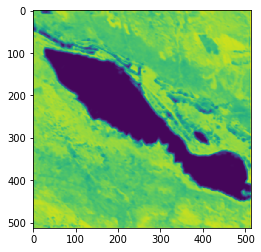

In [9]:
plt.imshow(a[0])

In [10]:
b = modis_utils.get_groundtruth('test', 10)

In [11]:
b.shape

(12, 513, 513)

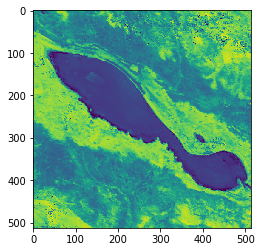

In [12]:
plt.imshow(b[0])

In [16]:
c = modis_utils.get_water_cloud_mask('test', 10)

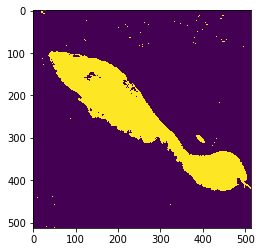

In [17]:
plt.imshow(c[0])

In [19]:
a = modis_utils.get_predict_mask_lake('test', 0)

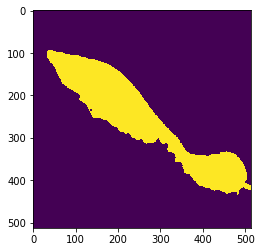

In [20]:
plt.imshow(a)

In [21]:
b = modis_utils.get_groundtruth_mask_lake('test', 0)

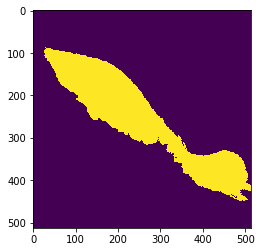

In [23]:
plt.imshow(b)

In [10]:
data_type = 'test'
predict_water_area = []
groundtruth_water_area = []
for i in range(modis_utils.get_n_tests(data_type)):
    predict_water_area.append(get_water_area(
        modis_utils.get_predict_mask_lake(data_type, i)))
    groundtruth_water_area.append(get_water_area(
        modis_utils.get_groundtruth_mask_lake(data_type, i)))

In [11]:
from modis_utils.misc import plot_two_arrays

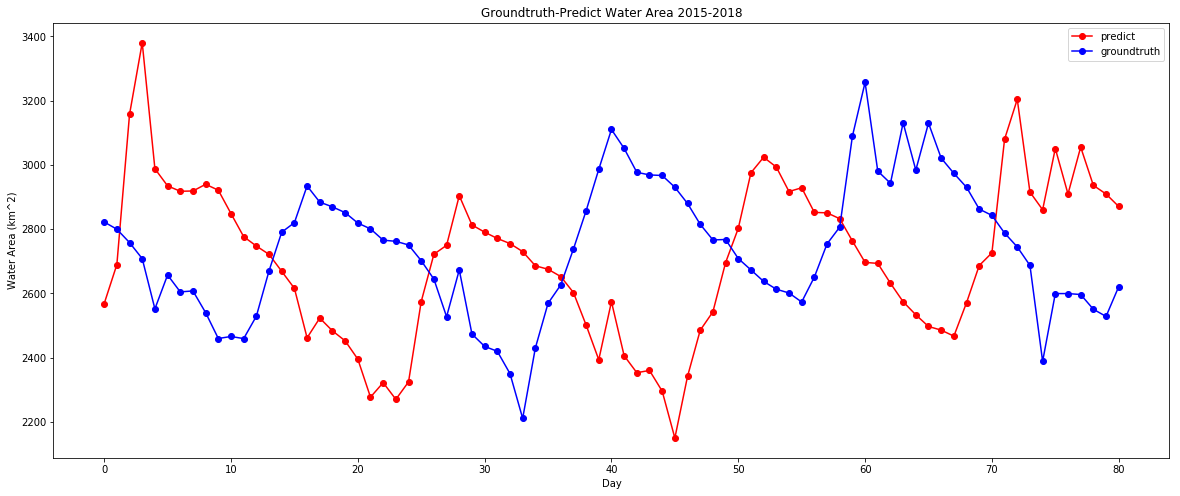

In [13]:
plot_two_arrays(predict_water_area, groundtruth_water_area, title='Groundtruth-Predict Water Area 2015-2018')

In [ ]:
with open('stat_{}.csv'.format(modis_utils._model_name), 'w') as f:
    for p, g in zip(predict_water_area, groundtruth_water_area):
        f.write('{:04f},{:04f}\n'.format(p, g))
    f.close()